In [26]:
import numpy as np
import pandas as pd
import tensorflow as tf
import matplotlib.pyplot as pyplot
from sklearn.model_selection import train_test_split

In [27]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [28]:
%cd drive/MyDrive/ml_data/

[Errno 2] No such file or directory: 'drive/MyDrive/ml_data/'
/content/drive/MyDrive/ml_data


In [29]:
train_csv_path = r'train.csv'
emotions = {0: 'Angry', 1:'Disgust', 2:'Fear',3: 'Happy', 4:'Sad', 5:'Surprise', 6:'Neutral'}
df = pd.read_csv(train_csv_path)
df.head(5)

,emotion,pixels
0,0,70 80 82 72 58 58 60 63 54 58 60 48 89 115 121...
1,0,151 150 147 155 148 133 111 140 170 174 182 15...
2,2,231 212 156 164 174 138 161 173 182 200 106 38...
3,4,24 32 36 30 32 23 19 20 30 41 21 22 32 34 21 1...
4,6,4 0 0 0 0 0 0 0 0 0 0 0 3 15 23 28 48 50 58 84...


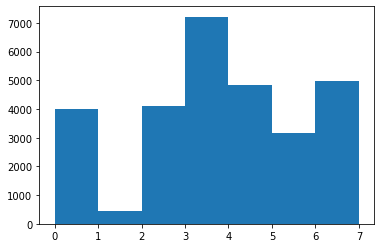

In [30]:
counts, bins = np.histogram(df['emotion'], list(range(0,8)))
pyplot.stairs(counts, bins, fill=True)

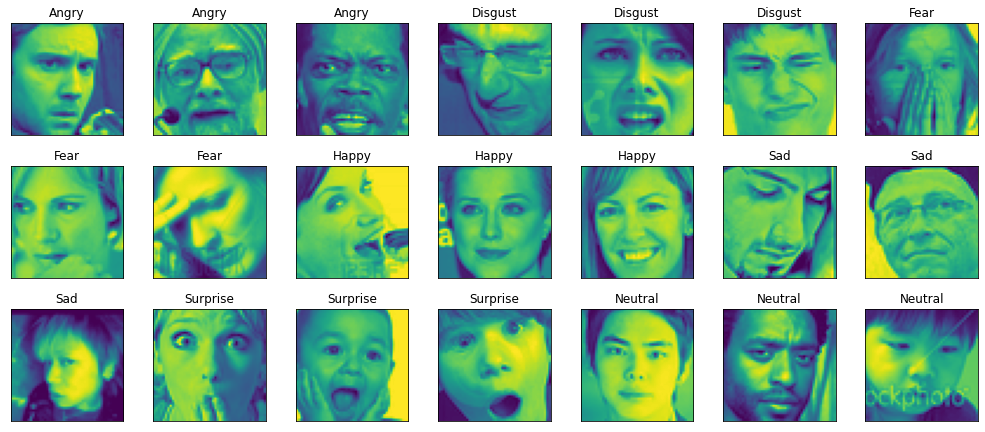

In [31]:
fig = pyplot.figure(1, (14, 14))
k = 0
for label in sorted(df.emotion.unique()):
    for j in range(3):
        px = df[df.emotion==label].pixels.iloc[k]
        px = np.array(px.split(' ')).reshape(48, 48).astype('float32')
        k += 1
        ax = pyplot.subplot(7, 7, k)
        ax.imshow(px)
        ax.set_xticks([])
        ax.set_yticks([])
        ax.set_title(emotions[label])
        pyplot.tight_layout()

In [32]:
img_array = df.pixels.apply(lambda px : np.array(px.split(' ')).reshape(48, 48, 1).astype('float32'))

In [33]:
img_array = np.stack(img_array, axis=0)
labels = df.emotion.values

In [34]:
X_train, X_test, y_train, y_test = train_test_split(img_array, labels, test_size=0.2)

In [35]:
X_train = X_train / 255.0
X_test = X_test / 255.0

In [65]:
basemodel = tf.keras.Sequential([
tf.keras.layers.Conv2D(64, (5,5), activation='relu', input_shape=(48, 48, 1), padding='same'),
tf.keras.layers.Conv2D(64, (5,5), activation='relu', padding='same'),
tf.keras.layers.BatchNormalization(),
tf.keras.layers.MaxPooling2D((2,2)),

tf.keras.layers.Conv2D(128, (5,5), activation='relu', padding='same'),
tf.keras.layers.Conv2D(128, (5,5), activation='relu', padding='same'),
tf.keras.layers.BatchNormalization(),
tf.keras.layers.MaxPooling2D((2,2)),

tf.keras.layers.Conv2D(256, (3,3), activation='relu', padding='same'),
tf.keras.layers.Conv2D(256, (3,3), activation='relu', padding='same'),
tf.keras.layers.BatchNormalization(),
tf.keras.layers.MaxPooling2D((2,2)),

tf.keras.layers.Flatten(),
tf.keras.layers.Dense(128, activation='relu'),
tf.keras.layers.Dropout(0.2),
tf.keras.layers.Dense(7, activation='softmax')
])

In [66]:
basemodel.summary()

Model: "sequential_7"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_30 (Conv2D)          (None, 48, 48, 64)        1664      
                                                                 
 conv2d_31 (Conv2D)          (None, 48, 48, 64)        102464    
                                                                 
 batch_normalization_12 (Bat  (None, 48, 48, 64)       256       
 chNormalization)                                                
                                                                 
 max_pooling2d_24 (MaxPoolin  (None, 24, 24, 64)       0         
 g2D)                                                            
                                                                 
 conv2d_32 (Conv2D)          (None, 24, 24, 128)       204928    
                                                                 
 conv2d_33 (Conv2D)          (None, 24, 24, 128)      

In [67]:
basemodel.compile(optimizer=tf.keras.optimizers.RMSprop(learning_rate=0.0001),
                  loss='sparse_categorical_crossentropy',
                  metrics=['accuracy'])

In [68]:
import os
try:
  os.mkdir('checkpoint')
except:
  pass

In [69]:
file_name = 'best_model.h5'
checkpoint_path = os.path.join('checkpoint', file_name)


call_back = tf.keras.callbacks.ModelCheckpoint(filepath=checkpoint_path, 
                                                 monitor='val_accuracy', 
                                                 verbose=1,
                                                 save_freq='epoch',
                                                 save_best_only=True, 
                                                 save_weights_only=False, 
                                                 mode='max')

In [70]:
basemodel.fit(X_train, y_train, epochs=20, validation_split=0.2, callbacks=call_back)

Epoch 1/20
572/575 [============================>.] - ETA: 0s - loss: 1.7768 - accuracy: 0.3033
Epoch 1: val_accuracy improved from -inf to 0.32368, saving model to checkpoint/best_model.h5
575/575 [==============================] - 51s 23ms/step - loss: 1.7763 - accuracy: 0.3035 - val_loss: 1.7804 - val_accuracy: 0.3237
Epoch 2/20
574/575 [============================>.] - ETA: 0s - loss: 1.5704 - accuracy: 0.3893
Epoch 2: val_accuracy improved from 0.32368 to 0.36221, saving model to checkpoint/best_model.h5
575/575 [==============================] - 13s 23ms/step - loss: 1.5706 - accuracy: 0.3892 - val_loss: 1.7653 - val_accuracy: 0.3622
Epoch 3/20
573/575 [============================>.] - ETA: 0s - loss: 1.4276 - accuracy: 0.4486
Epoch 3: val_accuracy did not improve from 0.36221
575/575 [==============================] - 13s 22ms/step - loss: 1.4274 - accuracy: 0.4488 - val_loss: 1.6677 - val_accuracy: 0.3439
Epoch 4/20
574/575 [============================>.] - ETA: 0s - loss: 1

Actual label is Neutral
1/1 [==============================] - 0s 19ms/step
Predicted label is Neutral


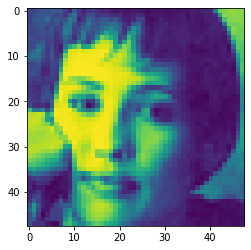

In [71]:
final_model = tf.keras.models.load_model(checkpoint_path)
from IPython.display import clear_output
import time

for k in range(3):
  print(f'Actual label is {emotions[y_test[k]]}')
  predicted_class = final_model.predict(tf.expand_dims(X_test[k], 0)).argmax()
  print(f'Predicted label is {emotions[predicted_class]}')
  pyplot.imshow(X_test[k])
  pyplot.show()
  time.sleep(3)
  clear_output(wait=True)
